In [1]:
%matplotlib inline
import sys
sys.path.insert(0, '/home/cnaik/s/3/ilp')

import numpy as np
import operator
from  utils import entailment
import json
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
process =  'evaporation'

In [3]:
def load_srl_data():
    d = json.load(open("/home/cnaik/s/3/ilp/data/test.srlpredict.json", "r"))
    data = {}
    for p_data in d:
        process = p_data['process']
        ss_data = p_data['sentences']
        sent_to_id = {}
        id_to_args = {}
        arg_role_scores = {}
        arg_role_srl_data = {}
        for s_data in ss_data:
            sentence = s_data['text']
            s_id = s_data['sentenceId']
            sent_to_id[sentence] = s_id
            a_spans = s_data['predictionArgumentSpan']
            args = []
            for a_span in a_spans:
                srl_role_prediction = a_span['rolePredicted']
                start_idx = a_span['startIdx']
                end_idx = a_span['endIdx']
                arg_text = a_span['text']
                arg_id = a_span['argId']
                role_prob_list = a_span['probRoles']
                args.append((arg_id, arg_text))
                role_probs = {}
                for role_prob in role_prob_list:
                    role_probs.update(role_prob)
                arg_role_scores[(s_id, arg_id)] = role_probs
                arg_role_srl_data[(s_id, arg_id)] = [srl_role_prediction, start_idx, end_idx]
            id_to_args[s_id] = args
        data[process] = [sent_to_id, id_to_args, arg_role_scores, arg_role_srl_data]
    return data

In [4]:
def get_arg(output_map, context):
    for s, val in output_map.iteritems():
        args = id_to_args[s]
        for a, aval in val.iteritems():
            arg = dict(args)[a]
            if context == (s, a):
                return arg
    return None

In [5]:
def get_similarity_score(arg1, arg2):
    ret = entailment.get_ai2_textual_entailment(arg1, arg2)
    a_scores = map(lambda x: x['score'], ret['alignments'])
    if len(a_scores):
        mean_a_score = np.mean(a_scores)
    else:
        mean_a_score = 0

    confidence = ret['confidence'] if ret['confidence'] else 0
    score1 = mean_a_score * confidence

    ret = entailment.get_ai2_textual_entailment(arg2, arg1)
    a_scores = map(lambda x: x['score'], ret['alignments'])
    if len(a_scores):
        mean_a_score = np.mean(a_scores)
    else:
        mean_a_score = 0

    confidence = ret['confidence'] if ret['confidence'] else 0
    score2 = mean_a_score * confidence
    return max(score1, score2)


In [6]:
srl_data = load_srl_data()

In [7]:
sent_to_id, id_to_args, arg_role_scores, arg_role_srl_data = srl_data[process]

In [8]:
sentences = {v: k for k, v in sent_to_id.iteritems()}

In [9]:
roles = ['undergoer', 'enabler', 'trigger', 'result', 'NONE']

f = open("../output/"+process+"_ilp.sol")
lines = f.readlines()
data = filter(lambda x: x.startswith('Z'), lines)
data =  map(lambda x: x[:-1], data)

In [10]:
output_map = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))
for d in data:
    var, ind = d.split(" ")
    var_ids = var.split("_")
    s = int(var_ids[1])
    a = int(var_ids[2])
    r = int(var_ids[3])
    output_map[s][a][r] = int(ind)

In [11]:
for s, val in output_map.iteritems():
    print s
    print "Sentence: ", sentences[s]
    args = id_to_args[s]
    for a, aval in val.iteritems():
        arg = dict(args)[a]
        for r, i in aval.iteritems():
            if i == 1:
                print "\t", arg, a, " - ", roles[r]
    print " "


384
Sentence: 

KeyError: 384

In [12]:
def get_all_args(output_map, context):
    all_args = set()
    for s, val in output_map.iteritems():
        args = id_to_args[s]
        for a, aval in val.iteritems():
            arg = dict(args)[a]
            if (s, a) != context[:2]:
                all_args.add((s, a, arg))
    return list(all_args)

In [13]:
# arg = (299, 0, 'water')
arg = (631, 1, 'losing')

In [14]:
all_args = get_all_args(output_map, arg)

KeyError: 384

In [15]:
all_args

NameError: name 'all_args' is not defined

In [438]:
my_data = {}
for s_id, a_id, arg2 in all_args:
    sim = get_similarity_score(arg[2], arg2)
    my_data[(arg[0], arg[1], s_id, a_id)] = (arg[2], arg2, sim)

In [439]:
my_data

{(631, 1, 21, 0): ('losing', u'number joining the liquid state', 0),
 (631, 1, 23, 0): ('losing', u'the pressure in a liquid-filled container', 0),
 (631, 1, 41, 0): ('losing',
  u'make the water form clouds from water vapour and condensation',
  0),
 (631, 1, 62, 0): ('losing',
  u'the impingement of a second sound thermal pulse',
  0),
 (631, 1, 62, 1): ('losing', u'caused', 0),
 (631, 1, 62, 2): ('losing', u'evaporation', 0),
 (631, 1, 62, 3): ('losing',
  u'the impingement of a second sound thermal pulse onto a he iivapor interface',
  0),
 (631, 1, 97, 0): ('losing', u'the conversion of water to gas', 0),
 (631, 1, 214, 0): ('losing', u'salt from seawater', 0),
 (631, 1, 229, 0): ('losing', u'water', 0),
 (631, 1, 272, 0): ('losing',
  u'the water to cool rapidly to its freezing point and it solidifies suddenly .',
  0),
 (631, 1, 340, 0): ('losing', u'adequate air movement over the lagoon', 0),
 (631, 1, 393, 0): ('losing', u'difference', 0),
 (631, 1, 470, 0): ('losing', u'prima

In [440]:
def get_assignment(output_map, s_id, r_id):
    role_map = {v: k for k, v in output_map[s_id][r_id].iteritems()}
    if 1 in role_map:
        return roles[role_map[1]]
    else:
        return 'NONE'
        

In [441]:
sorted_data = sorted(my_data.items(), key=lambda i:i[1][2], reverse=True)

In [442]:
map(lambda x: x[1], sorted_data[:min(len(sentences), 5)])

[('losing', u'turns', 0.00046248121170077474),
 ('losing', u'difference', 0),
 ('losing',
  u'the impingement of a second sound thermal pulse onto a he iivapor interface',
  0),
 ('losing',
  u'the water to cool rapidly to its freezing point and it solidifies suddenly .',
  0),
 ('losing', u'causes', 0)]

In [443]:
other_roles = defaultdict(int)
for x in sorted_data[:min(len(sentences), 5)]:
    ids, vals = x
    s_id1, a_id1, s_id2, a_id2 = ids
    original_role = get_assignment(output_map, s_id1, a_id1)
    other_roles[get_assignment(output_map, s_id2, a_id2)] += 1
    print original_role, vals, get_assignment(output_map, s_id2, a_id2)
    

trigger ('losing', u'turns', 0.00046248121170077474) trigger
trigger ('losing', u'difference', 0) trigger
trigger ('losing', u'the impingement of a second sound thermal pulse onto a he iivapor interface', 0) undergoer
trigger ('losing', u'the water to cool rapidly to its freezing point and it solidifies suddenly .', 0) undergoer
trigger ('losing', u'causes', 0) trigger


In [444]:
other_roles

defaultdict(int, {'trigger': 3, 'undergoer': 2})

trigger


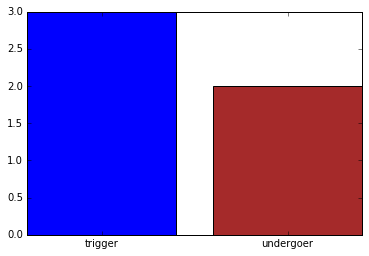

In [445]:
print original_role

if original_role in other_roles:
    original_role_count = other_roles[original_role]
    other_roles.pop(original_role)
else:
    original_role_count = 0

    
plt.bar([0], [original_role_count], align='center')
plt.bar(range(1, len(other_roles)+1), other_roles.values(), align='center', color='brown')
plt.xticks(range(len(other_roles)+1), [original_role] + list(other_roles.keys()))

# plt.bar(range(1, len(other_roles)+1), other_roles.values(), align='center')
# plt.xticks(range(1, len(other_roles)+1), list(other_roles.keys()))

plt.show()